# Import des librairies

In [100]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import random
import seaborn as sns
import shutil
import time, datetime
from tqdm.autonotebook import tqdm

import sklearn.metrics as metrics

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
import torchvision
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchsummary import summary
from collections import Counter

torch.cuda.empty_cache()
print(torch.cuda.is_available())
print(torch.__version__)
! nvidia-smi

False
2.1.1
Sun Dec 10 00:17:17 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      On | 00000000:04:00.0 Off |                  N/A |
| 29%   24C    P8               20W / 250W|      1MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-------------

# Extraction des données

In [101]:
# !tar -xzvf ../data/archive.tar.gz --warning=no-unknown-keyword --exclude='._*' --exclude='.DS_Store'  -C ../data/

# Préparation et split des données d'entrainement, de validation et de test

In [102]:
class DatasetOrganizer:
    """
    Organizes a dataset into train, validation, and test sets if the train folder doesn't exist.
    """

    def __init__(self, class_names, root_dir, source_dirs, test_ratio=0.1, val_ratio=0.1):
        """
        Initializes the DatasetOrganizer with parameters.

        Args:
        - class_names (list): List of class names.
        - root_dir (str): Root directory of the dataset.
        - source_dirs (list): List of directories containing class-wise images.
        - test_ratio (float, optional): Ratio for the test set. Defaults to 0.1.
        - val_ratio (float, optional): Ratio for the validation set. Defaults to 0.1.
        """
        self.class_names = class_names
        self.root_dir = root_dir
        self.source_dirs = source_dirs
        self.test_ratio = test_ratio
        self.val_ratio = val_ratio

    def organize_dataset(self):
        """
        Organizes the dataset into train, validation, and test sets if the train folder doesn't exist.
        """
        train_dir = os.path.join(self.root_dir, 'train')
        test_dir = os.path.join(self.root_dir, 'test')
        val_dir = os.path.join(self.root_dir, 'val')

        # Check if source directories exist
        if not all(os.path.exists(os.path.join(self.root_dir, source_dir)) for source_dir in self.source_dirs):
            print("Source directories not found. Skipping organization.")
            return
        
        try:
            # Check if train folder exists, if not, create directories and move images
            if not os.path.exists(train_dir):
                # Create directories for train, test, and val sets
                for directory in [train_dir, test_dir, val_dir]:
                    os.mkdir(directory)

                # Move images to train directory and create test/val directories
                for i, d in enumerate(self.source_dirs):
                    os.rename(os.path.join(self.root_dir, d), os.path.join(train_dir, self.class_names[i]))

                    for directory in [os.path.join(test_dir, self.class_names[i]), os.path.join(val_dir, self.class_names[i])]:
                        os.mkdir(directory)

                    train_images = [x for x in os.listdir(os.path.join(train_dir, self.class_names[i])) if x.lower().endswith('png')]

                    # Move images to test set
                    selected_images = random.sample(train_images, int(len(train_images) * self.test_ratio))
                    for image in selected_images:
                        source_path = os.path.join(train_dir, self.class_names[i], image)
                        target_path = os.path.join(test_dir, self.class_names[i], image)
                        shutil.move(source_path, target_path)

                    # Move images to validation set
                    remaining_images = [x for x in os.listdir(os.path.join(train_dir, self.class_names[i])) if x.lower().endswith('png')]
                    selected_images = random.sample(remaining_images, int(len(remaining_images) * self.val_ratio))
                    for image in selected_images:
                        source_path = os.path.join(train_dir, self.class_names[i], image)
                        target_path = os.path.join(val_dir, self.class_names[i], image)
                        shutil.move(source_path, target_path)
            else:
                print("Splits already done. Skipping organization.")

        except Exception as e:
            print(f"An error occurred: {e}")

class_names = ['normal', 'viral', 'covid']
root_dir = '../data/xrays_dataset'
source_dirs = ['Normal/images', 'Pneumonia/images', 'COVID/images']

dataset_organizer = DatasetOrganizer(class_names, root_dir, source_dirs)
dataset_organizer.organize_dataset()
root_dir = '../data'

Source directories not found. Skipping organization.


# Visualisation des données

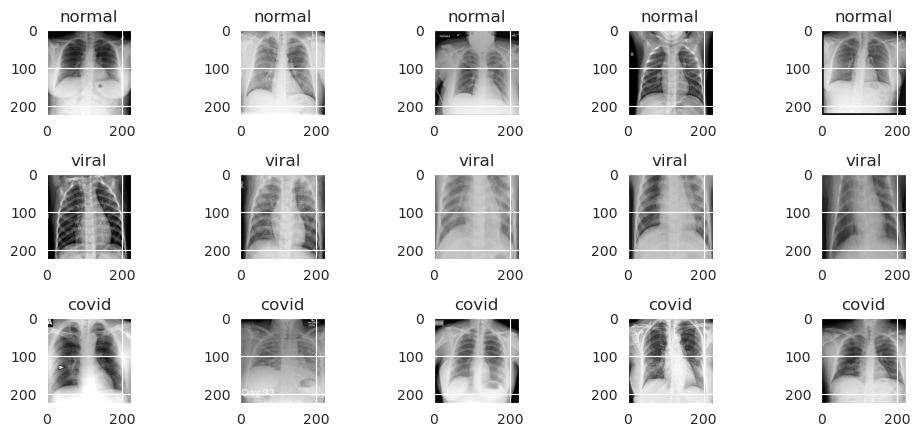

In [103]:
def show_images():
    """
    Display sample images from each class in the training set.
    Assumes the existence of predefined class_names and root_dir.
    """
    img_size = 224
    plt.figure(0, figsize=(10, 10))
    ctr = 0

    # Loop through each class
    for class_name in class_names:
        class_path = os.path.join(root_dir, "train", class_name)

        # Display the first 5 images of each class
        for i, filename in enumerate(os.listdir(class_path)[:5]):
            ctr += 1
            plt.subplot(7, 5, ctr)  # Create subplots for each image

            img_path = os.path.join(class_path, filename)
            img = Image.open(img_path)
            img = img.resize((img_size, img_size))
            plt.imshow(img, cmap='gray')
            plt.title(class_name)  # Set the title as the class name

    plt.tight_layout()
    plt.show()

show_images()

# Distribution des données

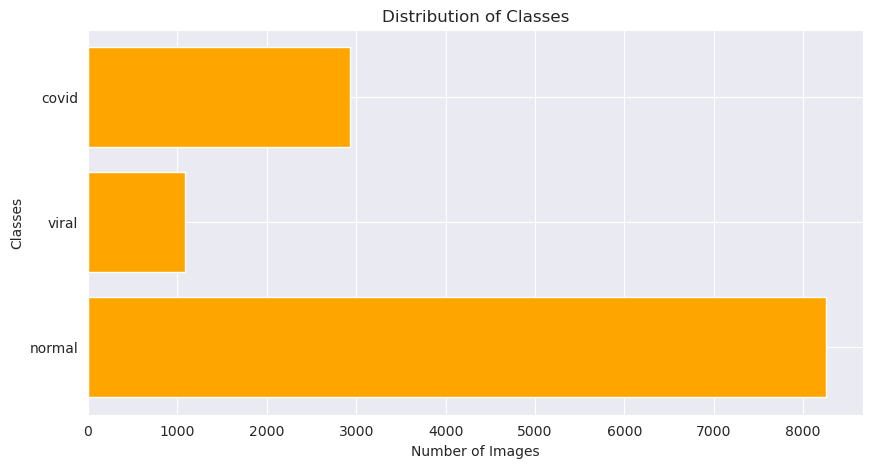

{'normal': 8256, 'viral': 1090, 'covid': 2930}


In [104]:
# Dictionary to store the training image distribution for each class
dist = {}
def plot_class_distribution():
    """
    Calculate the distribution of images for each class and plot the distribution.

    """

    # Calculate the image count for each class
    for class_name in class_names:
        class_path = os.path.join(root_dir, 'train', class_name)
        
        # Filter out only PNG images in the directory
        images = [x for x in os.listdir(class_path) if x.lower().endswith('.png')]
        
        # Store the count of images for each class in the 'dist' dictionary
        dist[class_name] = len(images)

    # Extract class names and their respective image counts
    courses = list(dist.keys())
    values = list(dist.values())

    # Plotting the distribution of classes
    plt.figure(figsize=(10, 5))
    plt.barh(courses, values, color='orange')

    plt.title("Distribution of Classes")
    plt.ylabel("Classes")
    plt.xlabel("Number of Images")
    plt.show()

plot_class_distribution()
print(dist)

# Création de la classe de Dataset

In [105]:
def contrast_stretching(img):
    data = np.array(img)
    gray_img = cv2.cvtColor(data, cv2.COLOR_RGB2GRAY)
    min_intensity = np.min(gray_img)
    max_intensity = np.max(gray_img)
    stretched_img = ((gray_img - min_intensity) / (max_intensity - min_intensity) * 255).astype(np.uint8)
    stretched_img = cv2.cvtColor(stretched_img, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(stretched_img)


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names =  list(image_dirs.keys())  # Use keys from image_dirs as class names
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        self.indices = [] 

        for class_name in self.class_names:
            num_images = len(self.images[class_name])
            self.indices.extend([(class_name, idx) for idx in range(num_images)])
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        class_name, idx = self.indices[index]
        image_name = self.images[class_name][idx]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        img = Image.open(image_path).convert('RGB')
        
        # Apply contrast stretching to the image
        img = contrast_stretching(img)
        
        return self.transform(img), self.class_names.index(class_name)


# Transformation et augmentation des images

In [106]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Préparation des DataLoader pour les batch

In [107]:
train_path = os.path.join(root_dir, 'train')

train_dirs = {
    'normal': os.path.join(train_path, 'normal'),
    'viral': os.path.join(train_path, 'viral'),
    'covid': os.path.join(train_path, 'covid')
}

train_dataset = CustomDataset(train_dirs, train_transform)

Found 8256 normal examples
Found 1090 viral examples
Found 2930 covid examples


In [108]:
val_path = os.path.join(root_dir, 'val')

val_dirs = {
    'normal': os.path.join(val_path, 'normal'),
    'viral': os.path.join(val_path, 'viral'),
    'covid': os.path.join(val_path, 'covid')
}

val_dataset = CustomDataset(val_dirs, val_transform)

Found 917 normal examples
Found 121 viral examples
Found 325 covid examples


In [109]:
test_path = os.path.join(root_dir, 'test')

test_dirs = {
    'normal': os.path.join(test_path, 'normal'),
    'viral': os.path.join(test_path, 'viral'),
    'covid': os.path.join(test_path, 'covid')
}

test_dataset = CustomDataset(test_dirs, test_transform)

Found 1019 normal examples
Found 134 viral examples
Found 361 covid examples


In [110]:
# Compute class weights based on the counts
total_samples_train = sum(dist.values())
class_weights = {cls: total_samples_train / count for cls, count in dist.items()}

# Collect labels directly
train_labels = [class_names[label] for _, label in tqdm(train_dataset, desc='Collecting labels')]

# Create a list of weights for each sample in the training dataset based on class weights
train_weights = [class_weights[label] for label in train_labels]

# Create a WeightedRandomSampler using the computed sample weights
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))

batch_size = 64

# Use the sampler in DataLoader while creating the training DataLoader
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
dl_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Création du modèle ResNet

In [111]:
class ResidualBlock(nn.Module):
    """
    Residual Block for the simplified ResNet architecture.

    Args:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - stride (int, optional): Stride for the convolutional layers. Defaults to 1.
    """

    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection for handling dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        """
        Forward pass through the ResidualBlock.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor.
        """
        residual = x

        out = f.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # If the input channels don't match the output channels after convolutions,
        # apply the shortcut connection to match dimensions
        if self.shortcut:
            residual = self.shortcut(residual)

        out += residual
        out = f.relu(out)
        return out

class ResNet18(nn.Module):
    """
    ResNet18 architecture.
    """

    def __init__(self):
        super(ResNet18, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        # Residual layers using ResidualBlocks
        self.layer1 = self._make_layer(ResidualBlock, 32, 32, 2, stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 32, 64, 2, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 64, 128, 2, stride=2)
        self.layer4 = self._make_layer(ResidualBlock, 128, 256, 2, stride=2)

        # Classifier
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * ResidualBlock.expansion, 3)

    def _make_layer(self, block, in_channels, out_channels, num_blocks, stride):
        """
        Create a layer with multiple blocks.

        Args:
        - block (nn.Module): Type of block to be used (e.g., ResidualBlock).
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - num_blocks (int): Number of blocks to be stacked.
        - stride (int): Stride for the first block.

        Returns:
        - nn.Sequential: Sequential layer containing multiple blocks.
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(in_channels, out_channels, stride))
            in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through ResNet18.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor.
        """
        out = f.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

def initialize_resnet18():
    """
    Initialize simplified ResNet-18 model.

    Returns:
    - ResNet18: Simplified ResNet-18 model instance.
    """
    return ResNet18()


In [112]:
setup = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model = initialize_resnet18().to(setup)
summary(my_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
            Conv2d-3         [-1, 32, 112, 112]           9,216
       BatchNorm2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]           9,216
       BatchNorm2d-6         [-1, 32, 112, 112]              64
     ResidualBlock-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 32, 112, 112]           9,216
       BatchNorm2d-9         [-1, 32, 112, 112]              64
           Conv2d-10         [-1, 32, 112, 112]           9,216
      BatchNorm2d-11         [-1, 32, 112, 112]              64
    ResidualBlock-12         [-1, 32, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]          18,432
      BatchNorm2d-14           [-1, 64,

# Fonctions d'entrainement et d'évaluation

In [113]:
def trainer(model, train_loader, val_loader=None, score_funcs={'Accuracy': metrics.accuracy_score}, device=setup, epochs=1, checkpoint_file='../models/resnet.pt'):
    """
    Trains a given model using the provided data loaders for a specified number of epochs.

    Args:
    - model (torch.nn.Module): The model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for training data.
    - val_loader (torch.utils.data.DataLoader, optional): DataLoader for validation data. Defaults to None.
    - score_funcs (dict, optional): Dictionary containing scoring functions. Defaults to {'Accuracy': metrics.accuracy_score}.
    - device (str, optional): Device for training the model. Defaults to setup.
    - epochs (int, optional): Number of epochs for training. Defaults to 1.
    - checkpoint_file (str, optional): Filepath to save model checkpoints. Defaults to '../models/resnet.pt'.

    Returns:
    - pd.DataFrame: DataFrame containing training and validation results.
    """

    # Define loss function and metrics to track
    loss_func = nn.CrossEntropyLoss()
    to_track = ["Epochs", "Time", "Train_Loss"]
    if val_loader is not None:
        to_track.append("Val_Loss")
    for eval_score in score_funcs:
        to_track.append("Train_" + eval_score)
        if val_loader is not None:
            to_track.append("Val_" + eval_score)

    total_train_time = 0
    results = {item: [] for item in to_track}

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):

        model = model.train()
        running_loss = 0.0
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            batch_size = inputs.shape[0]

            optimizer.zero_grad()
            y_hat = model(inputs)
            loss = loss_func(y_hat, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            for i in range(batch_size):
                y_true.append(labels[i])
                y_pred.append(y_hat[i, :])

        end = time.time()
        total_train_time += (end - start)

        results["Epochs"].append(epoch + 1)
        results["Time"].append(str(datetime.timedelta(seconds=total_train_time)))
        results["Train_Loss"].append(running_loss)

        y_pred = np.asarray(y_pred)

        if y_pred.shape[1] > 1:
            y_pred = np.argmax(y_pred, axis=1)

        for name, score_func in score_funcs.items():
            results["Train_" + name].append(score_func(y_true, y_pred) * 100)

        if val_loader is not None:
            model = model.eval()
            y_true = []
            y_pred = []
            running_loss = 0.0

            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                y_hat = model(inputs)
                loss = loss_func(y_hat, labels)
                running_loss += loss.item() * inputs.size(0)

                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(len(labels)):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i, :])

            results["Val_Loss"].append(running_loss)
            y_pred = np.asarray(y_pred)

            if y_pred.shape[1] > 1:
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["Val_" + name].append(score_func(y_true, y_pred) * 100)

        if checkpoint_file is not None:
            torch.save({
                'Epochs': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results': results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)


def evaluator(model, pred_label, true_label, ps_label, dataset, correct, total, accuracy):
    """
    Evaluates a model on a given dataset and computes accuracy.

    Args:
    - model (torch.nn.Module): The model to be evaluated.
    - pred_label (list): List to store predicted labels.
    - true_label (list): List to store true labels.
    - ps_label (list): List to store labels.
    - dataset (torch.utils.data.DataLoader): DataLoader for evaluation.
    - correct (int): Count of correct predictions.
    - total (int): Total count of predictions.
    - accuracy (float): Accuracy of the model.

    Returns:
    - tuple: Tuple containing updated predicted labels, true labels, dataset, correct predictions count, total predictions count, and accuracy.
    """
    with torch.no_grad():
        for images, labels in dataset:
            model.eval()
            output = model(images.to(setup))
            output = (torch.max(torch.exp(output), 1)[1]).detach().cpu().numpy()
            pred_label.extend(output)
            labels = labels.numpy()
            true_label.extend(labels)
            total += len(labels)
            correct += (output == labels).sum().item()
        accuracy = correct / total
        return pred_label, true_label, ps_label, dataset, correct, total, accuracy

# Entrainement du modèle ResNet

In [114]:
model_results = trainer(my_model, train_loader=dl_train, val_loader=dl_val, epochs=30)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/192 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Résultats de l'entrainement du modèle ResNet

In [ ]:
model_results

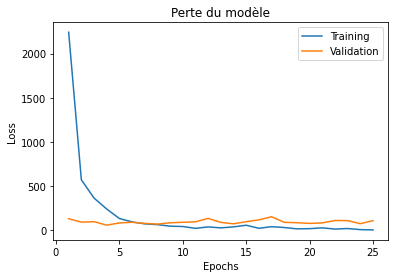

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='Epochs', y='Train_Loss', data=model_results, label='Training')
sns.lineplot(x='Epochs', y='Val_Loss', data=model_results, label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.show()

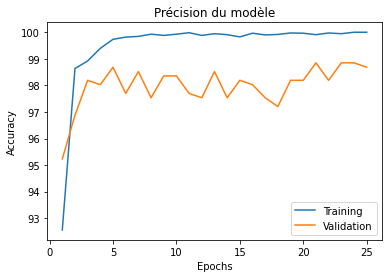

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='Epochs', y='Train_Accuracy', data=model_results, label='Training')
sns.lineplot(x='Epochs', y='Val_Accuracy', data=model_results, label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()

# Évaluation du modèle ResNet18

In [ ]:
test_pred_labels = []
test_true_labels = []
ps_list = []
running_correct = 0.0
running_total = 0.0
accuracy_test=0.0

model_evaluation = evaluator(my_model,test_pred_labels,test_true_labels,ps_list,dl_test,running_correct,running_total,accuracy_test)

In [ ]:
print("Total Correct Images: {} | Total Test Images: {}".format(int(model_evaluation[4]), int(model_evaluation[5])))
print("Test Accuracy: ", model_evaluation[6]*100)

Total Correct Images: 2990 | Total Test Images: 3030
Test Accuracy:  98.67986798679867


In [ ]:
print("Classification report for test set:\n%s\n"
      % (metrics.classification_report(model_evaluation[1], model_evaluation[0],target_names=class_names)))

Classification report for test set:
              precision    recall  f1-score   support

      NORMAL       0.97      0.99      0.98      1048
   PNEUMONIE       1.00      0.97      0.99       988
    COVID-19       0.99      0.99      0.99       994

    accuracy                           0.99      3030
   macro avg       0.99      0.99      0.99      3030
weighted avg       0.99      0.99      0.99      3030


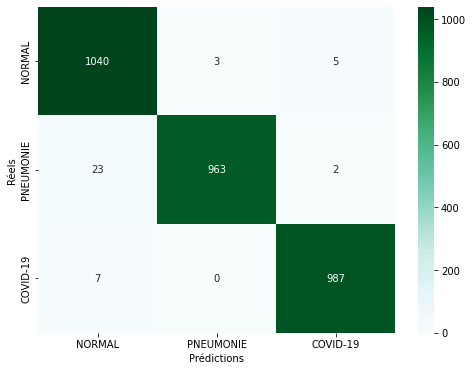

In [ ]:
arr = metrics.confusion_matrix(test_true_labels, test_pred_labels)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (10, 5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Prédictions")
plt.ylabel("Réels")
plt.show()